<a href="https://colab.research.google.com/github/marcos626/Redes_neuronales/blob/main/redes-neuronales-2024-guia-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# El modelo *Integrate and Fire*

## Teoría

El modelo *Integrate and Fire* del comportamiento de una neurona viene descripto por dos ingredientes. En primer lugar, la ODE

\begin{eqnarray}
\frac{dV}{dt}
&=&
\frac{1}{\tau}
\left(
E-V(t)
+
RI(t)
\right)
\end{eqnarray}

donde:

* $V(t)$ representa el potencial de membrana al tiempo $t$,

* $E\approx -65mV$ representa el potencial de reposo,

* $\tau\approx 10ms$ representa el tiempo de relajación,

* $R\approx 10M\Omega$ representa una resistencia eléctrica, y

* $I(t)\approx 1nA$ representa una corriente/señal de entrada.

En segundo lugar, un mecanismo de disparo definido por

\begin{eqnarray}
V(t) \to E
\end{eqnarray}

cuando

\begin{eqnarray}
V(t) > V_u
\end{eqnarray}

donde:

* $V_u \approx -50mV$ representa un potencial umbral.

Es decir, según el mecanismo de disparo, el potencial de membrana $V(t)$ se resetea a su valor de reposo $E$ si supera cierto valor umbral $V_u$.

## Unidades

* p = pico = $10^{-12}$
* n = nano = $10^{-9}$
* $\mu$ = micro = $10^{-6}$
* m = mili = $10^{-3}$
* ...
* k = kilo = $10^{3}$
* M = Mega = $10^{6}$
* G = Giga = $10^{9}$
* T = Tera = $10^{12}$

### Ley de Ohm

Si $\Omega$ = Ohmio, V = Voltio y A = Amper, entonces

$$ 1\, Ohm = 1 \Omega = \frac{1 V}{1 A} $$

### Ley RC

Si s = segundos y F = Faradios, entonces

$$ 1 s = 1 \Omega \times 1 F $$

### Hertz

Si Hz = Hertz, luego

$$ 1 Hz = \frac{1}{1 s} $$

### Referencias

* https://technologystudent.com/elec1/ohm1.htm

* https://en.wikipedia.org/wiki/Biological_neuron_model#Leaky_integrate-and-fire

* https://compneuro.neuromatch.io/tutorials/W2D3_BiologicalNeuronModels/student/W2D3_Tutorial1.html



## **Ejercicio 1)** Importando librerías

**1)** Importe las librerías `numpy` para operar con arrays, `scipy` para utilizar rutinas de algebra lineal y `matplotlib.pyplot` para graficar.

**2)** Suba el archivo "libreria" `ode.py` que fabricó en el práctico 4), e impórtelo.

In [96]:
# 1.1)
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [97]:
# 1.2)
#import ode

def euler(f,x,t,h,p):
    """
    Calcula un paso de integración del método de Euler.

    Argumentos de entrada:

        f : R^n,R -> R^n
        x = x(t) : R^n
        t = tiempo : R
        h = paso de tiempo : R
        p = parametros : R^q

    Retorna aproximacion numérica de

        x(t+h) : R^n

    según el método de Euler.

    # Ejemplos:
    """
    return x+h*f(x,t,p)

def rk4(f,x,t,h,p):
    """
    Calcula un paso de integración del método de Runge Kutta orden 4.

    Argumentos de entrada:

        f : R^n -> R^n
        x = x(t) : R^n
        t = tiempo : R
        h = paso de tiempo : R
        p = parametros : R^q

    Retorna aproximacion numérica de

        x(t+h) : R^n

    según el método de Runge-Kutta de orden 4.

    # Ejemplos:
    """
    k1 = f(x,t,p)
    k2 = f(x+0.5*h*k1,t+0.5*h,p)
    k3 = f(x+0.5*h*k2,t+0.5*h,p)
    k4 = f(x+h*k3,t+h,p)
    return x+h*(k1+2.0*k2+2.0*k3+k4)/6.0

def integrador_ode(m,f,xa,a,b,k,p,c=lambda x,t,p:x):
    """
    Integra numéricamente la ODE

        dx/dt = f(x,t)

    sobre el intervalo t:[a,b] usando k pasos de integración y el método m, bajo condicion inicial x(a)=x0.
    No es necesario que a<b.

    Argumentos de entrada:

        m = metodo de integracion (ej. euler, rk2, etc.)
        f : R^n -> R^n
        xa = condicion inicial : R
        a = tiempo inicial : R
        b = tiempo final : R
        k = num. pasos de integracion : N
        p = parametros : R^q
        c = función condicionante : R^n,R,p -> R^n

    Retorna:

        t : R^{k+1} , t_j = a+j*h para j=0,1,...,k
        w : R^{n,k+1} , w_ij = x_i(t_j) para i=0,1,...,n-1 y j=0,1,...,k

    donde a+k*dt = b.
    """
    assert k>0
    n = len(xa)
    h = (b-a)/k
    w = np.zeros((n,k+1)) # Produce un array con forma y tipo especificada con los parametros,
                          # lleno de ceros. la forma puede ser espcificada con un entero o tupla (n,k+1)
    t = np.zeros(k+1)
    w[:,0] = xa           # actualiza la posicion inicial (columna de indice 0) de las variables con los valores
                          # de las condiciones iniciales
    t[0] = a              # actualiza la posicion cero con el valor del tiempo inicial

    for j in range(k):    #Aca se produce la iteración en j

        t[j+1] = t[j] + h                # iteracion tiempo
        w[:,j+1] = m(f,w[:,j],t[j],h,p)  # iteracion de w
        w[:,j+1] = c(w[:,j+1],t[j+1],p)  # condicion sobre w

    return t,w

## **Ejercicio 2)** Dinámica con mecanismo de disparo desactivado

En lo que sigue, se considera desactivado el mecanismo de disparo.

**1)** Resuelva analíticamente la ODE del modelo *Integrate and Fire* para una condición inicial arbitraria $V(0)=V_0$ y una corriente de entrada $I=0$.

**2)** Grafique la solución para $V_0=10mV$ y $t\in [0,100]ms$. Incorpore al gráfico una línea punteada indicando el potencial de reposo.

**3)** Realice un análisis geométrico de la solución calculada. Incorpore flechas del campo vectorial así como los puntos fijos estables, inestables y marginales, si los hubiere.

**4)** Repita **1)**, **2)** y **3)** para el caso de corriente de entrada constante, $I=2$nA.

### Extra

**5)** Resuelva analíticamente la ODE para una corriente de entrada $I:t\to I(t)$ arbitraria.

In [98]:
# 2.2)
E = -65  # mV
tau = 10  # ms
V0 = 10  # mV
umbral = -50  # mV
valores_t = np.linspace(0, 100, 100)  # ms
valores_V = np.vectorize(V)(valores_t)

In [99]:
# Solución de la ODE
def V(t):
  return E + (V0 - E) * np.exp(-t / tau)

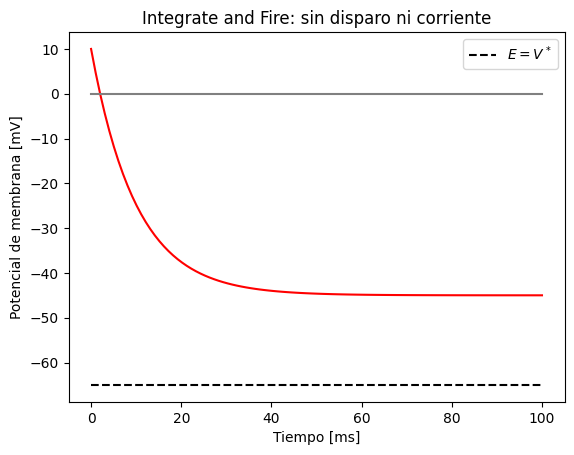

In [100]:
plt.xlabel('Tiempo [ms]')
plt.ylabel('Potencial de membrana [mV]')
plt.plot(valores_t, valores_V, label = "", linestyle = '-', c = 'red')
plt.plot(valores_t,np.zeros(len(valores_t)),label = "", linestyle = '-', c = 'gray')
plt.plot(valores_t,E*np.ones(len(valores_t)),label = "$E = V^*$", linestyle = '--', c = 'black')
plt.title('Integrate and Fire: sin disparo ni corriente')
plt.legend()

In [101]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=valores_t, y=valores_V, mode='lines', name='Potencial de membrana', line=dict(color='red')))
fig.add_trace(go.Scatter(x=valores_t, y=np.zeros(len(valores_t)), mode='lines', name='Línea base', line=dict(color='gray')))
fig.add_trace(go.Scatter(x=valores_t, y=E*np.ones(len(valores_t)), mode='lines', name='$E = V^*$', line=dict(dash='dash', color='black')))

fig.update_layout(
    title='Integrate and Fire: sin disparo ni corriente',
    xaxis_title='Tiempo [ms]',
    yaxis_title='Potencial de membrana [mV]',
    legend_title='Leyenda'
)

fig.show()

In [102]:
Vfix = E
def f(V):
    return (E-V)/tau
valores_V = np.linspace(-120,20,100)
valores_f = np.vectorize(f)(valores_V)

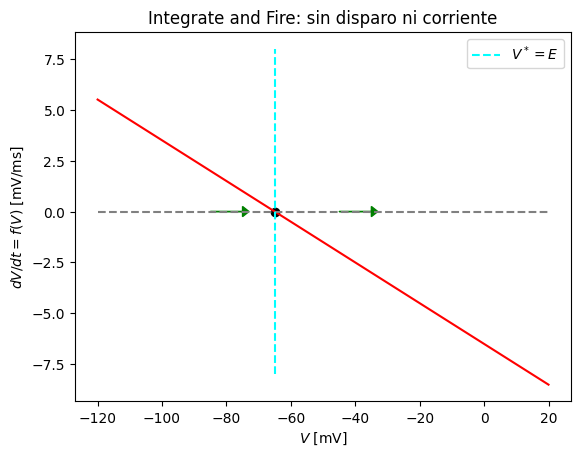

In [103]:
plt.xlabel('$V$ [mV]')
plt.ylabel('$dV/dt=f(V)$ [mV/ms]')
plt.plot(valores_V,valores_f, label = "", linestyle = '-', c = 'red')
plt.plot(valores_V,np.zeros(len(valores_V)),label = "", linestyle = '--', c = 'gray')
plt.plot([Vfix,Vfix],[-8,8],label="$V^*=E$", linestyle = '--', c = 'cyan')
plt.arrow(Vfix-20.0,0.0,10.0,0.0,head_width=0.5,head_length=2,fc='g',ec='g')
plt.arrow(Vfix+20.0,0.0,10.0,0.0,head_width=0.5,head_length=2,fc='g',ec='g')
plt.scatter([Vfix],[0],c='black')
plt.title('Integrate and Fire: sin disparo ni corriente')
plt.legend()

In [104]:
# 2.4.2)
E = -65 #mV
tau = 10 #ms
V0 = 10 #mV
I = 2 #nA
R = 10 #Mohms
Vfix = E+I*R
def V(t):
    return Vfix+(V0-Vfix)*np.exp(-t/tau)

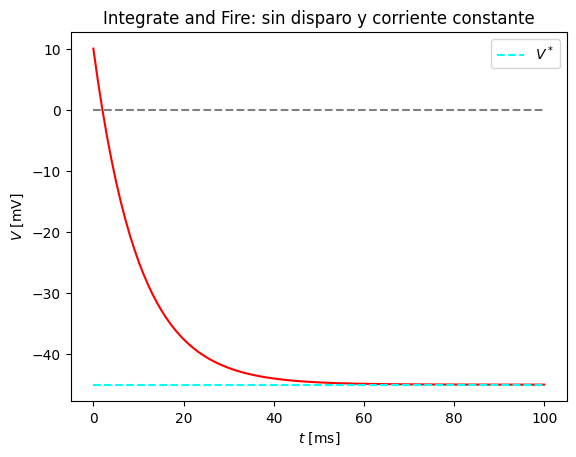

In [105]:
plt.xlabel('$t$ [ms]')
plt.ylabel('$V$ [mV]')
valores_t = np.linspace(0,100,100)
valores_V = np.vectorize(V)(valores_t)
plt.plot(valores_t,valores_V, label = "", linestyle = '-', c = 'red')
plt.plot(valores_t,[Vfix]*len(valores_t), label = "$V^*$", linestyle = '--', c = 'cyan')
plt.plot(valores_t,np.zeros(len(valores_t)),label = "", linestyle = '--', c = 'gray')
plt.title('Integrate and Fire: sin disparo y corriente constante')
plt.legend()

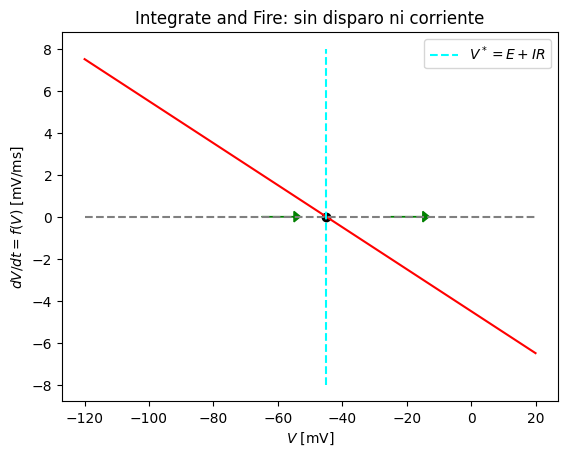

In [106]:
def f(V):
    return (Vfix-V)/tau
plt.xlabel('$V$ [mV]')
plt.ylabel('$dV/dt=f(V)$ [mV/ms]')
valores_V = np.linspace(-120,20,100)
valores_f = np.vectorize(f)(valores_V)
plt.plot(valores_V,valores_f, label = "", linestyle = '-', c = 'red')
plt.plot(valores_V,np.zeros(len(valores_V)),label = "", linestyle = '--', c = 'gray')
plt.plot([Vfix,Vfix],[-8,8],label="$V^*=E+IR$", linestyle = '--', c = 'cyan')
plt.arrow(Vfix-20.0,0.0,10.0,0.0,head_width=0.5,head_length=2,fc='g',ec='g')
plt.arrow(Vfix+20.0,0.0,10.0,0.0,head_width=0.5,head_length=2,fc='g',ec='g')
plt.scatter([Vfix],[0],c='black')
plt.title('Integrate and Fire: sin disparo ni corriente')
plt.legend()

## **Ejercicio 3)** Dinámica con mecanismo de disparo activado

**1)** Resuelva numéricamente la ODE del modelo *Integrate and Fire* en el intervalo $t\in [0,200]ms$ para la condición inicial $V(0)=E$ y una corriente de entrada $I(t)=I_0$ para todo $t$ con $I_0=2nA$. Utilice el paso de integración $h=0.05ms$.

**2)** Grafique la solución computada en el inciso **3.1)**. Incorpore al gráfico la solución exacta del inciso **2.1)**, en donde el mecanismo de disparo está desactivado, para la misma condición inicial del inciso **3.1)**. Grafique, también, líneas punteadas horizontales marcando los valores de $V^*$ y $V_u$, donde $V^*$ es el valor de $V$ tal que $f(V)=0$.

**3)** Para el caso indicado en el inciso **3.1)**, calcule analíticamente el período de disparo.
Observe si el valor computado corresponde con el observado en el inciso **3.2)**.
Grafíque la frencuencia en función de $I_0$.
Que ocurre para valores pequeños de $I_0$?


**4)** Repita **3.1)** y **3.2)** con $I_e(t)=I_0 \cos(t/30ms)$ e $I_0=2.5nA$ para $0\,ms\leq t\leq 500\,ms$. En este caso, no incluya la solución exacta del inciso **2.1)**, pero sí lineas punteadas horizontales para marcar los valores de $E$ y $V_u$.

**5)** Repita **3.1)** y **3.2)** con

\begin{equation}
I(t)= I_0 \, \left(
    \cos{\left( \frac{t}{3ms} \right)} +
    \sin{\left( \frac{t}{5ms} \right)} +
    \cos{\left( \frac{t}{7ms} \right)} +
    \sin{\left( \frac{t}{11ms} \right)} +
    \cos{\left( \frac{t}{13ms} \right)}  \right)^2 \, nA \,
    \;\;\;(4)
\end{equation}

e $I_0=0.35 nA$ para $0\,ms\leq t\leq 200\,ms$. Al igual que en inciso anterior, no incluya la solución exacta del inciso **2.a)**, pero sí lineas punteadas horizontales para marcar los valores de $E$ y $V_u$.

In [107]:
# 3.1)
E = -65  # mV
tau = 10  # ms
V0 = 10  # mV
Vu = -50  # mV

p = [E,tau,R,I,Vu]

def f(x,t,p):
  """
  V =   x[0]
  E =   p[0]
  tau = p[1]
  R =   p[2]
  I =   p[3]
  Vu =  p[4]

  donde I : t -> I(t)
  """
  V   = x[0]
  E   = p[0]
  tau = p[1]
  R   = p[2]
  I   = p[3]
  #Vu  = p[4]
  return np.array([(E+R*I(t)-V)/tau])

def c(x,t,p):
  """
  V = x[0]
  E = p[0]
  tau = p[1]
  R = p[2]
  I = p[3]
  Vu = p[4]

  donde I : t -> I(t)
  """
  V   = x[0]
  E   = p[0]
  #tau = p[1]
  #R   = p[2]
  #I   = p[3]
  Vu  = p[4]
  if V>Vu:
    V=E
  return np.array([V])

In [108]:
a = 0  # ms
b = 200  # ms
xa = np.array([E])
h = 0.05  # ms
k = int((b-a)/h)

In [109]:
t,W = integrador_ode(rk4,f,xa,a,b,k,p,c=c)
W[0,:]

TypeError: 'int' object is not callable